In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext dotenv
%dotenv

In [79]:
import pandas as pd
import logging
import scipy
import numpy as np
import matplotlib.pyplot as plt
from galaxies import read_nxs_file

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Calibration")
logger.setLevel(logging.INFO)

# Calibration with the Yb elastic scattering data

Read 6 images with 6 energies
Image size: (6, 195, 487)


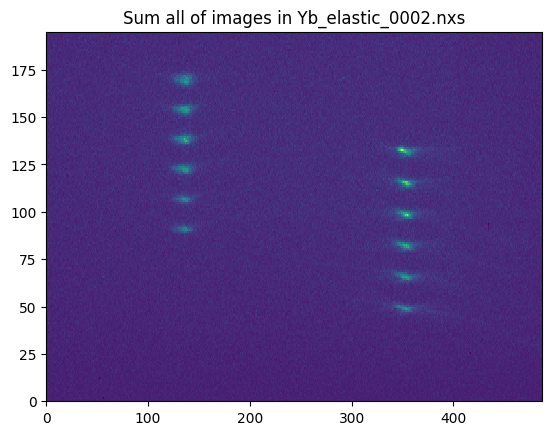

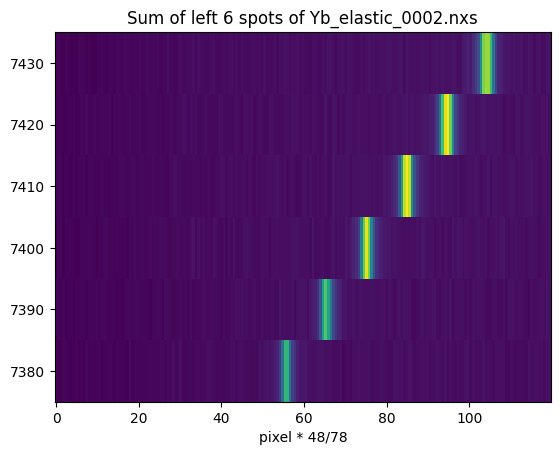

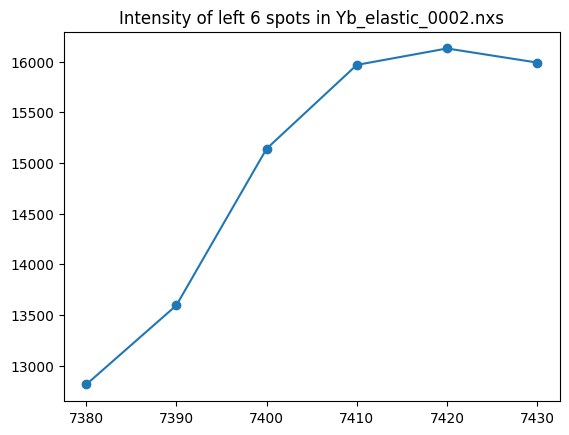

In [27]:
def foo():
    filename = 'Yb_elastic_0002.nxs'
    data = read_nxs_file(filename)
    pilatus_image = data['images']
    energy = data['energies']
    print("Read {} images with {} energies".format(len(pilatus_image), len(energy)))
    print("Image size: {}".format(pilatus_image.shape))
    plt.title("Sum all of images in " + filename)
    plt.pcolormesh(np.sum(pilatus_image,axis=0))
    plt.show()
    plt.title("Sum of left 6 spots of " + filename)
    plt.pcolormesh(np.arange(0,195)/78*48,energy,np.sum(pilatus_image[:,:,115:155],axis=2))
    plt.xlabel("pixel * 48/78")
    plt.show()
    plt.title("Intensity of left 6 spots in " + filename)
    plt.plot(energy,np.sum(pilatus_image[:,:,115:155],axis=(1,2)), 'o-')

foo()

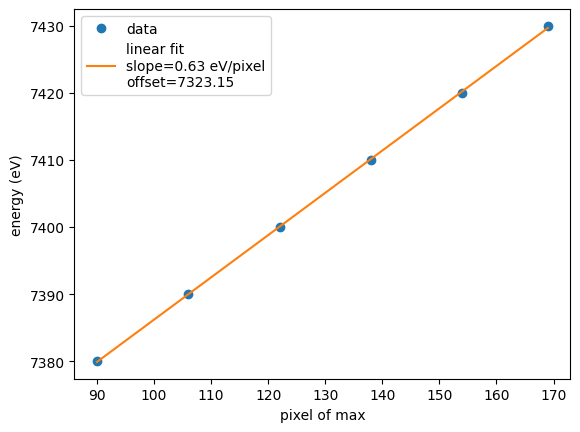

array([6.30496275e-01, 7.32314863e+03])

In [34]:
def foo():
    data = read_nxs_file('Yb_elastic_0002.nxs')
    pilatus_image = data['images']
    energy = data['energies']
    maxpos = []
    for i in range(len(pilatus_image)):
        maxpos.append(np.argmax(np.sum(pilatus_image[i,:,115:155], axis=1)))
    p = np.polyfit(maxpos,energy,1)

    plt.figure(4)
    plt.clf()
    plt.plot(maxpos,energy,'o', label="data")
    plt.plot(maxpos,np.polyval(p,maxpos),'-', label="linear fit\nslope={:.2f} eV/pixel\noffset={:.2f}".format(p[0], p[1]))
    plt.legend()
    plt.xlabel('pixel of max')
    plt.ylabel('energy (eV)')
    plt.show()
    return p

foo()

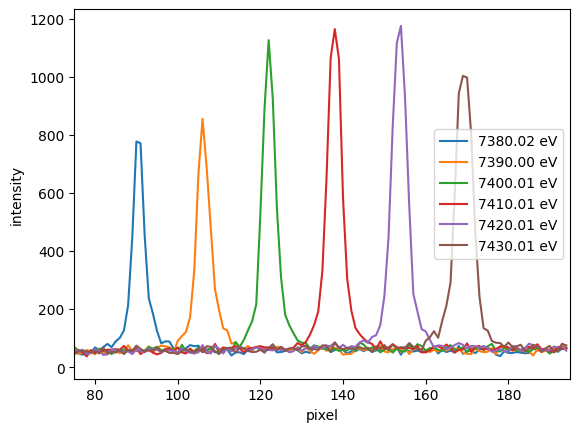

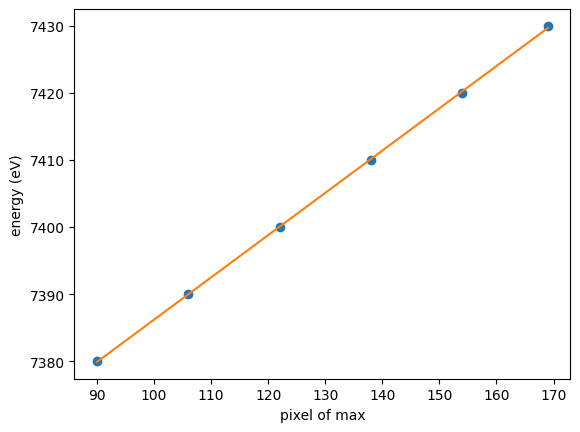

array([6.30496275e-01, 7.32314863e+03])

In [26]:
def foo():
    data = read_nxs_file('Yb_elastic_0002.nxs')
    pilatus_image = data['images']
    energy = data['energies']
    for data, e in zip([np.sum(im[:,115:155],axis=1) for im in pilatus_image], energy):
        plt.plot(data, label="{:.2f} eV".format(e))
    plt.xlabel("pixel")
    plt.xlim(75,195)
    plt.ylabel("intensity")
    plt.legend()
    plt.show()
    maxpos = [np.argmax(np.sum(im[:,115:155],axis=1)) for im in pilatus_image]
    p = np.polyfit(maxpos,energy,1)

    plt.figure(4)
    plt.clf()
    plt.plot(maxpos,energy,'o')
    plt.plot(maxpos,np.polyval(p,maxpos),'-')
    plt.xlabel('pixel of max')
    plt.ylabel('energy (eV)')
    plt.show()
    return p

foo()

In [61]:
def fit_gaussian(ser: np.ndarray):

    def gaussian(xx, area, cen, sigma, offset):
        return area * (1/(np.sqrt(2.0 * np.pi) * sigma)) * np.exp(-(xx - cen) ** 2 / (2 * sigma ** 2)) + offset

    x = np.arange(len(ser))
    y = ser  #.values
    p0 = [y.max(), x[np.argmax(y)], 1, 0]  # initial guess
    popt, _ = scipy.curve_fit(gaussian, x, y, p0=p0)
    return popt

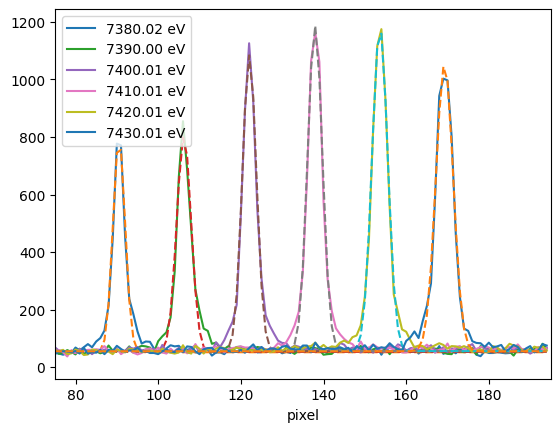

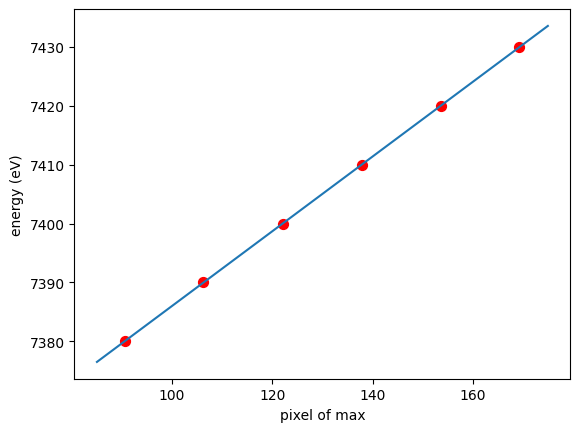

[6.34133926e-01 7.32260335e+03]
Slope: 0.63413 eV/pixel, Offset: 7322.60335 eV


,energy,area,center,sigma,offset,FWHM [eV]
0,7380.016641,740.015568,90.531025,1.475355,51.683582,2.203274
1,7390.001995,752.209065,106.225902,1.748573,52.810516,2.611293
2,7400.006722,1029.518506,122.067438,1.689284,55.28512,2.522753
3,7410.010430,1130.977754,137.941855,1.788847,55.875506,2.671439
4,7420.007139,1123.810962,153.645483,1.891001,55.395364,2.823993
5,7430.005474,998.018221,169.278946,2.0979,55.085977,3.132974


In [97]:
def foo():
    data = read_nxs_file('Yb_elastic_0002.nxs')
    pilatus_image = data['images']
    energy = data['energies']
    fit_par = pd.DataFrame(columns=['area', 'center', 'sigma', 'offset'], index=pd.Series(energy, name='energy'))
    for data, e in zip([np.sum(im[:,115:155],axis=1) for im in pilatus_image], energy):
        popt = fit_gaussian(data)
        plt.plot(data, label="{:.2f} eV".format(e))
        # plot gaussian fit
        x = np.arange(len(data))
        plt.plot(x, popt[0] * np.exp(-(x - popt[1]) ** 2 / (2 * popt[2] ** 2)) + popt[3], '--')
        plt.xlim(75,195)
        fit_par.loc[e] = popt
    plt.xlabel("pixel")
    plt.legend()
    plt.show()

    p = np.polyfit(list(fit_par["center"]), fit_par.index.values, 1)
    pix = np.arange(85, 180, 10)
    plt.plot(pix, np.polyval(p, pix),'-')
    fit_par.reset_index().plot(x="center", y="energy", kind="scatter", s=50, color='r', ax=plt.gca())
    plt.xlabel('pixel of max')
    plt.ylabel('energy (eV)')
    plt.show()

    print(p)
    print("Slope: {:.5f} eV/pixel, Offset: {:.5f} eV".format(p[0], p[1]))
    fit_par["FWHM [eV]"] = 2.355 * fit_par["sigma"] * p[0]
    return fit_par.reset_index()

foo()

# Calibration on sample elastics

## Function definitions

In [166]:
def calibrate_line(*, filename: str, roi, line_ends: tuple, vmax=None, plot=True):

    logger.info("Reading %s with ROI=%s and points %s", filename, str(roi), str(line_ends))
    data = read_nxs_file(filename)
    pilatus_image = data['images']
    energy = data['energies']
    logger.debug("Read %i images with %i energies", len(pilatus_image), len(energy))
    logger.debug("Image tensor dimensions: {}".format(pilatus_image.shape))

    logger.debug("ROI: {}".format(roi))
    sum_of_spots = np.sum(pilatus_image[:, :, roi[0]:roi[1]], axis=2)

    fig, ax1, ax2 = None, None, None
    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(12, 4))
        ax1.set_title(f"Sum ROI {roi[0]}-{roi[1]} of {filename}")
        g1 = ax1.pcolormesh(np.arange(0, 195), energy, sum_of_spots, vmax=vmax)
        ax1.grid(True, which='major')
        ax1.tick_params(axis="both", which="both", bottom=True, top=True, left=True, right=True)
        ax1.minorticks_on()
        plt.colorbar(g1, ax=ax1)
        ax1.set_xlabel("pixel")
        ax1.set_ylabel("Incident Energy [eV]")


    approx_line_ene2pix = np.polyfit(line_ends[0], line_ends[1], 1)
    logger.debug("Approx slope from manual points: {:.5f} pixel/eV, offset: {:.5f}".format(*approx_line_ene2pix))

    pixel_x = []
    pixel_e = []
    for e, data in zip(energy, sum_of_spots):
        x_max = int(np.polyval(approx_line_ene2pix,e))
        if x_max > data.shape[0]:
                continue
        # find max value around x_max
        i = np.argmax(data[x_max-5:x_max+5])
        pixel_x.append(i+ x_max - 5)
        pixel_e.append(e)
    df = pd.DataFrame({"energy": pixel_e, 'pixel': pixel_x})

    line_pix2ene = np.polyfit(df['pixel'], df['energy'], 1)
    logger.info("Fit: %.5f ev/pixel, offset=%.3f", *line_pix2ene)

    if plot:
        df.set_index('pixel').plot(style="o", ax=ax2)
        x_axis = np.arange(*line_ends[1])
        ax2.plot(x_axis, np.polyval(line_pix2ene, x_axis), '-', label=f"calibration fit, {line_pix2ene[0]:.5f} eV/pixel")
        ax2.legend()
        fig.tight_layout()

    out = {
        "line_pix2ene": line_pix2ene,
        "df": df,
        "energy": energy,
        "sum_of_spots": sum_of_spots,
        "filename": filename,
        "plot": plot,
    }
    return out

In [156]:
def extract_elastic_fwhm(*, energy: np.ndarray, sum_of_spots: np.ndarray, line_pix2ene: np.ndarray, filename: str, plot=True, **opts):

    fig, ax1, ax2 = None, None, None
    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(12, 4))

    # y=kx+n, x = (y-n)/k = y/k - n/k
    e2pix_calibration = [1/line_pix2ene[0], -line_pix2ene[1]/line_pix2ene[0]]

    elastics = []
    energies = []
    x_maxs = []
    for e, data in zip(energy, sum_of_spots):
        x_max = int(np.polyval(e2pix_calibration, e))
        if x_max > data.shape[0]:
            continue
        # extract areas around x_max
        i = data[x_max-10 : x_max+10]
        elastics.append(i)
        energies.append(e)
        x_maxs.append(x_max)

    results = {'Incident Energy [eV]': [], 'FWHM [eV]': []}
    for e, data, x_max in zip(energies, elastics, x_maxs):
        # xs = np.arange(x_max-10, x_max+10, 1)
        xs = np.arange(-10, +10, 1) * line_pix2ene[0]
        ys = data
        if len(xs) != len(ys):
            continue
        if plot and ax1:
            ax1.plot(xs, ys, label=f"{e:.2f}) eV")
        # extract width
        w = get_full_width(xs, ys)
        results['FWHM [eV]'].append(w)
        results['Incident Energy [eV]'].append(e)

    if plot and ax1:
        ax1.set_title(f"Elastics for '{filename}', N={len(elastics)}")
        ax1.set_xlabel("Energy [eV]")

    df = pd.DataFrame.from_dict(results)

    if plot and ax2:
        df.plot(x="Incident Energy [eV]", y="FWHM [eV]", ax=ax2)
        fig.tight_layout()

    return df

In [157]:
def get_full_width(x: np.ndarray, y: np.ndarray, height: float = 0.5) -> float:
    height_half_max = np.max(y) * height
    index_max = np.argmax(y)
    x_low = np.interp(height_half_max, y[:index_max+1], x[:index_max+1])
    x_high = np.interp(height_half_max, np.flip(y[index_max:]), np.flip(x[index_max:]))

    return x_high - x_low


## Run

INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[80, 110] and points ((2460, 2476), (117, 190))
INFO:Calibration:Fit: 0.21316 ev/pixel, offset=2435.029
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[315, 340] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20378 ev/pixel, offset=2443.588


Electrode_07_0004.nxs 1.282032962968217
Electrode_07_0004.nxs 0.9607708575173152


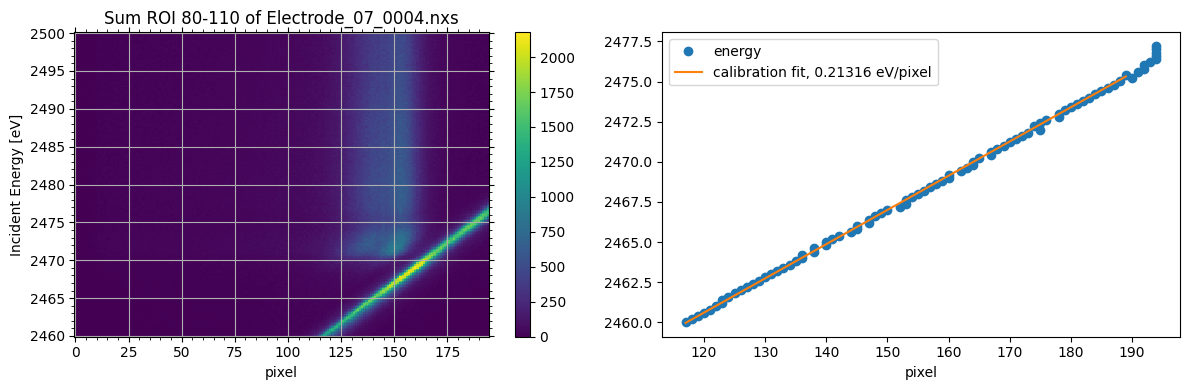

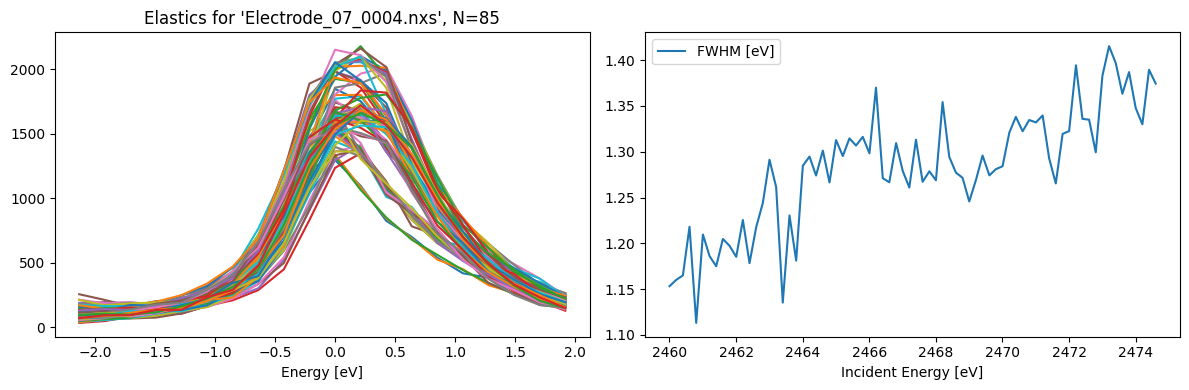

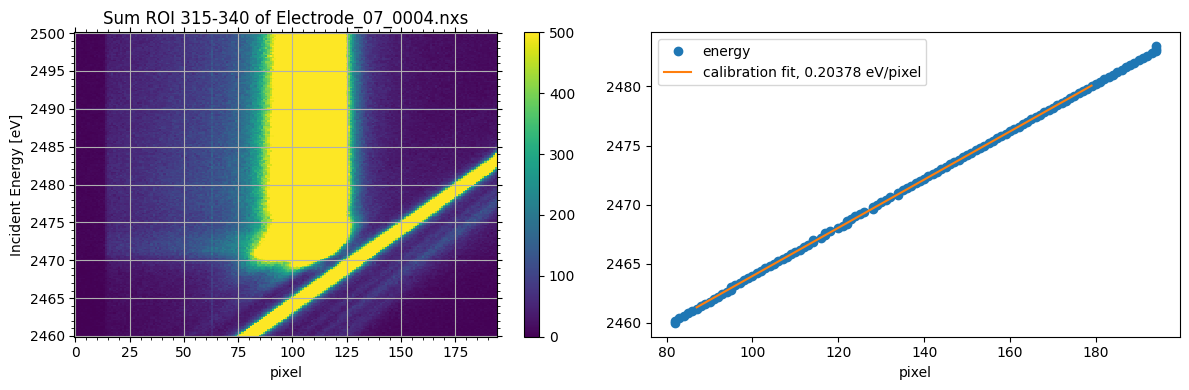

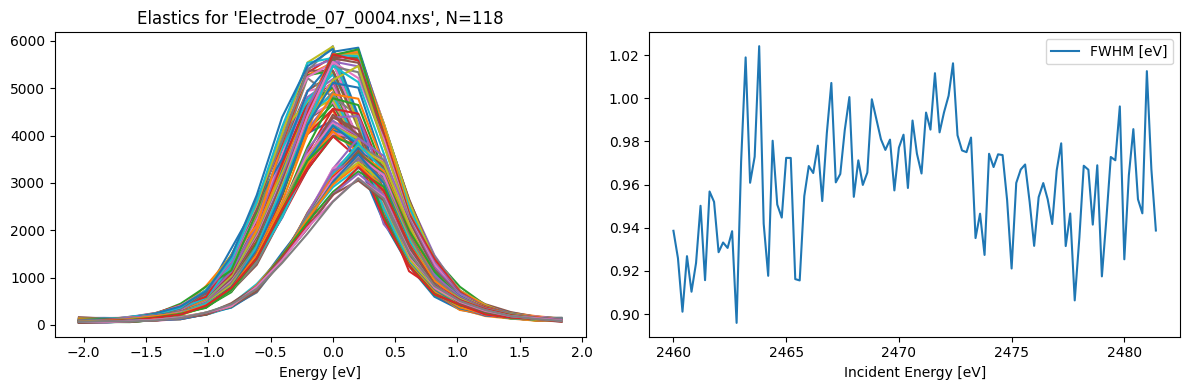

In [176]:
def foo():
    # logger.setLevel(logging.DEBUG)
    input_data = ({
        'filename': 'Electrode_07_0004.nxs',
        'roi': [80, 110],
        'line_ends': ((2460, 2476), (117, 190))
        },
        {
        'filename': 'Electrode_07_0004.nxs',
        'roi': [315, 340],
        'vmax': 500,
        'line_ends': ((2460, 2480), (87, 180))
        },
    )

    for idata in input_data:
        results = calibrate_line(**idata, plot=True)
        df = extract_elastic_fwhm(**results)
        print(idata['filename'], df['FWHM [eV]'].mean())

    logger.setLevel(logging.INFO)

foo()

**TODO:** change ROI width and see how FWHM of elastic changes.

INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[301, 311] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20694 ev/pixel, offset=2442.345
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[311, 321] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20346 ev/pixel, offset=2443.219
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[321, 331] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20222 ev/pixel, offset=2443.689
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[331, 341] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20503 ev/pixel, offset=2443.525
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[341, 351] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20319 ev/pixel, offset=2443.585
INFO:Calibration:Reading Electrode_07_0004.nxs with ROI=[351, 361] and points ((2460, 2480), (87, 180))
INFO:Calibration:Fit: 0.20249 ev/pixel, offset=2443.607
INFO:Calibration:Reading Electrode_07_00

,offsets,fwhms
0,1,1.956126
1,11,1.035750
2,21,0.746292
3,31,0.838882
4,41,0.955571
5,51,1.776328
6,61,2.541847


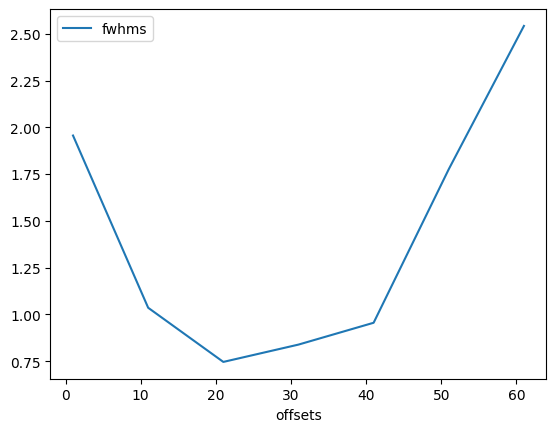

In [190]:
def foo():
    def input_data(offset=0, width=5):
        return {
        'filename': 'Electrode_07_0004.nxs',
        'roi': [300 + offset, 300 + offset + width],
        'vmax': None,
        'line_ends': ((2460, 2480), (87, 180))
        }

    offsets = []
    fwhms = []
    # go from 305 -- 370
    for offset in range(1, 70, 10):
        idata = input_data(offset=offset, width=10)
        results = calibrate_line(**idata, plot=False)
        df = extract_elastic_fwhm(**results)
        fwhms.append(df['FWHM [eV]'].mean())
        offsets.append(offset)

    results_df = pd.DataFrame({"offsets": offsets, "fwhms": fwhms})
    results_df.plot(x="offsets", y="fwhms")

    return results_df

foo()